In [1]:

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 17122 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Grape Black Measles',
 'Grape Black rot',
 'Grape Healthy',
 'Grape Isariopsis Leaf Spot',
 'No Son Hojas']

In [5]:
len(dataset)

536

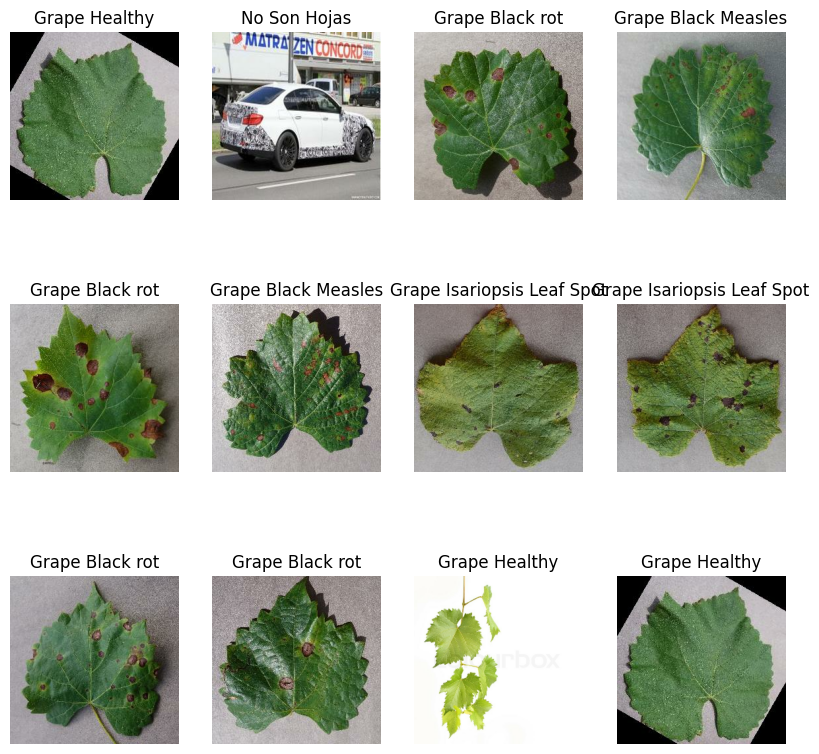

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")
    

In [7]:
len(dataset)

536

In [8]:
train_percentage = 80  # 80% entrenamiento
validation_percentage = 10  # 10% validación
test_percentage = 10  # 10% prueba

In [9]:
train_size = 0.8
len(dataset) * train_size

428.8

In [10]:
train_ds = dataset.take(81)
len(train_ds)

81

In [11]:
test_ds = dataset.skip(81)
len(test_ds) 

455

In [12]:
val_size = 0.1
len(test_ds) * val_size

45.5

In [13]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [14]:
test_ds = test_ds.skip(9)
len(test_ds)

446

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(428, 53, 55)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),  
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),  
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

c:\Users\candy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,845 (1.33 MB)

 Trainable params: 347,845 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]

)


Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.6190 - loss: 0.8809 - val_accuracy: 0.8650 - val_loss: 0.3512
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 397s 925ms/step - accuracy: 0.9239 - loss: 0.2362 - val_accuracy: 0.9693 - val_loss: 0.1252
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 375s 876ms/step - accuracy: 0.9543 - loss: 0.1438 - val_accuracy: 0.9399 - val_loss: 0.1746
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 379s 884ms/step - accuracy: 0.9585 - loss: 0.1348 - val_accuracy: 0.9829 - val_loss: 0.0652
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 333s 779ms/step - accuracy: 0.9634 - loss: 0.1118 - val_accuracy: 0.9870 - val_loss: 0.0414
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 352s 823ms/step - accuracy: 0.9764 - loss: 0.0764 - val_accuracy: 0.9882 - val_loss: 0.0326
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 355s 831ms/step - accuracy: 0.9795 - loss: 0.0642 - val_accuracy: 0.9693 - val_loss: 0.0900
Epoch 8/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 357s 833ms/step - accuracy: 0.9819 - lo

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

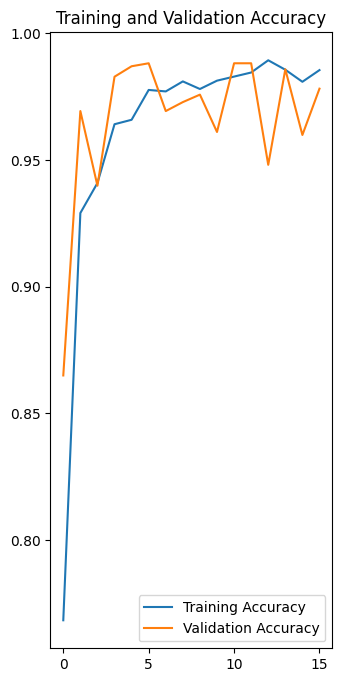

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
epochs_range = range(len(acc))  # Adjust range to match the length of accuracy lists
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

Primera imagen para predecir
Etiqueta Actual: No Son Hojas
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicciones del modelo: No Son Hojas


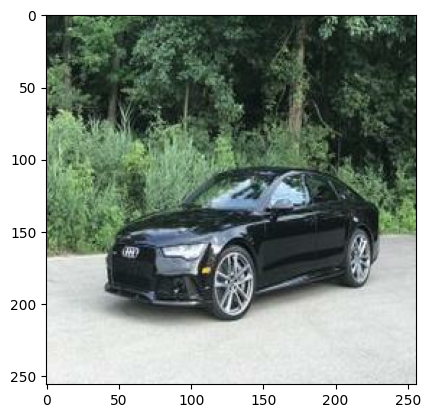

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("Primera imagen para predecir")
    plt.imshow(first_image)
    print("Etiqueta Actual:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicciones del modelo:", class_names[np.argmax(batch_prediction[0])])

In [29]:
import os

model_version = 4
save_dir = r"C:\Users\candy\Documents\Python\PlantasEnf\modelo"  # Ruta especificada
os.makedirs(save_dir, exist_ok=True)  # Crear el directorio si no existe
model.save(os.path.join(save_dir, f"{model_version}.keras"))

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


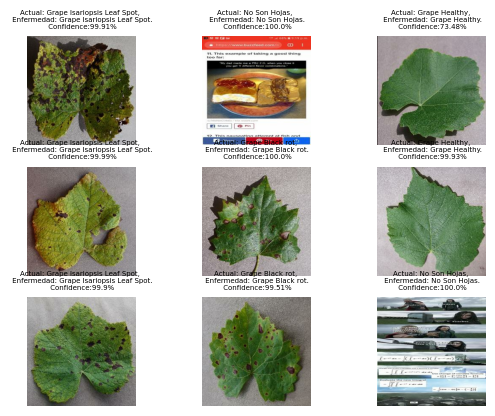

In [31]:
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Enfermedad: {predicted_class}.\n Confidence:{confidence}%", fontsize=5)
        plt.axis("off")

In [32]:
import tensorflow as tf

# Imprimir la versión de TensorFlow
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0
